In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import torch
sys.path.append("../../")
from TCN.soil_classification.model import SimpleVAE
from TCN.soil_classification.utils import data_generator, data_generator_test
from TCN.soil_classification.model_VAE import DenseVAE, ConvVAE
from TCN.soil_classification.model import TCN
from TCN.soil_classification.model_classifier import LatentClassifier
from sklearn.metrics import confusion_matrix
import time

from sklearn import metrics
from sklearn.manifold import TSNE

In [3]:
# Definitions for data indicies
LIN_ACC_X = 1
LIN_ACC_Y = 2
LIN_ACC_Z = 3
ANG_VEL_X = 4
ANG_VEL_Y = 5
ANG_VEL_Z = 6
ORIENT_X = 7
ORIENT_Y = 8
ORIENT_Z = 9
ORIENT_W = 10
POS_X = 11
POS_Z = 12
ANG = 13
BOOM = 14
DIPPER = 15
TELE = 16
PITCH = 17
labels = ["lin_acc_x","lin_acc_y","lin_acc_z","ang_vel_x","ang_vel_y","ang_vel_z", "ori_x", "ori_y",
          "ori_z", "ori_w", "pos_x", "pos_z", "ang", "boom", "dipper", "tele", "pitch"]

In [31]:
test_folder = "/home/mads/git/TCN/TCN/soil_classification/data/prelim_downsample_phase"
train_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/train"
val_folder = "/home/mads/git/TCN/TCN/soil_classification/data/exp_1604/test"


#class_model = "models_latent_class/latent_class6_3232_bs256_do0_seq128_imu_no_orient_phase2_nlf8/latent_class6_3232_bs256_do0_seq128_imu_no_orient_phase2_nlf8_ep78.pt"
#class_model = "models_latent_class/latent_class11_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/latent_class11_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep78.pt"
#class_model = "models_latent_class/latent_class_KL0045rel_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/latent_class_KL0045rel_3232_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep80.pt"
class_model = "models_latent_class/latent_class_grad_3232_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8/latent_class_grad_3232_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8_ep80.pt"
#class_model = "models_latent_class/latent_class_norm_3232_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8/latent_class_norm_3232_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8_ep80.pt"
class_model_grad_norm = "models_latent_class/latent_class_3232_bs256_do0_seq128_imu_no_orient_norm_derivative_phase2_nlf8/latent_class_3232_bs256_do0_seq128_imu_no_orient_norm_derivative_phase2_nlf8_ep80.pt"

ConvVAE_8 = "AE_model/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAE_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"
ConvVAE_8_2 = "AE_model/ConvVAE_KL0045rel_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAE_KL0045rel_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep64.pt"
ConvVAED_8_grad = "AE_model/ConvVAED_Test14_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8/ConvVAED_Test14_bs256_do0_seq128_imu_no_orient_derivative_phase2_nlf8_ep128.pt"
ConvVAED_8_norm = "AE_model/ConvVAED_Test13_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8/ConvVAED_Test13_bs256_do0_seq128_imu_no_orient_norm_phase2_nlf8_ep128.pt"
ConvVAED_8_norm_grad = "AE_model/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_nlf8/ConvVAED_Test16_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_nlf8_ep128.pt"


ConvVAED_8 = "AE_model/ConvVAED_Test6_bs256_do0_seq128_imu_no_orient_phase2_nlf8/ConvVAED_Test6_bs256_do0_seq128_imu_no_orient_phase2_nlf8_ep128.pt"
#ConvVAED_8 = "AE_model/ConvVAED_Test11_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8/ConvVAED_Test11_bs256_do0_seq128_imu_no_orient+torques_phase2_nlf8_ep128.pt"
#TCN_model = "models_3/TCN_bs256_do0_seq128_imu_no_orient+torques_phase2/TCN_bs256_do0_seq128_imu_no_orient+torques_phase2_ep50.pt"
TCN_model = "models_3/TCN_bs256_do25_seq128_imu_no_orient_phase2/TCN_bs256_do25_seq128_imu_no_orient_phase2_ep40.pt"
TCN_model_acc = "models_3/TCN_bs256_do25_seq128_only_acceleration_phase2/TCN_bs256_do25_seq128_only_acceleration_phase2_ep40.pt"
TCN_model_grad = "models_3/TCN_bs256_do25_seq128_imu_no_orient_derivative_phase2/TCN_bs256_do25_seq128_imu_no_orient_derivative_phase2_ep12.pt"
TCN_model_norm = "models_3/TCN_bs256_do25_seq128_imu_no_orient_norm_phase2/TCN_bs256_do25_seq128_imu_no_orient_norm_phase2_ep40.pt"
TCN_model_aug = "models_3/TCN_bs256_do25_seq128_imu_no_orient_augment_phase2/TCN_bs256_do25_seq128_imu_no_orient_augment_phase2_ep40.pt"
TCN_model_augfull = "models_3/TCN_bs256_do25_seq128_imu_no_orient_augmentFull_phase2/TCN_bs256_do25_seq128_imu_no_orient_augmentFull_phase2_ep40.pt"
TCN_model_grad_norm = "models_3/TCN_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2/TCN_bs256_do25_seq128_imu_no_orient_norm_derivative_phase2_ep6.pt"
TCN_model_8_norm_grad_t = "models_3/TCN_bs256_seed1_do25_seq128_imu_no_orient_norm_derivative+torque_phase2/TCN_bs256_seed1_do25_seq128_imu_no_orient_norm_derivative+torque_phase2_ep40.pt"


variable_set = [list(range(LIN_ACC_X,ANG_VEL_Z+1,1))+list(range(BOOM,PITCH+1,1))]
#variable_set = [list(range(LIN_ACC_X,ANG_VEL_Z+1,1))]
#variable_set = [list(range(LIN_ACC_X,LIN_ACC_Z+1,1))]

seq_len = 128
#seq_len = 100
phase = 2

X_train, Y_train = data_generator(train_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])
X_test, Y_test = data_generator(test_folder, seq_len, seq_len-1, phase =phase, val_mask=variable_set[0])

#mask = Y_test > 0
#X_test, Y_test = X_test[mask], Y_test[mask]


norm = True
derivative = True
seq_standard = False
if norm:
    X_train[:,:,0] = torch.linalg.norm(X_train[:,:,0:3], dim = 2)
    X_train[:,:,1] = torch.linalg.norm(X_train[:,:,3:6], dim = 2)
    X_train = X_train[:,:,[0,1]+list(range(6,X_train.shape[2],1))]
    
    X_test[:,:,0] = torch.linalg.norm(X_test[:,:,0:3], dim = 2)
    X_test[:,:,1] = torch.linalg.norm(X_test[:,:,3:6], dim = 2)
    X_test = X_test[:,:,[0,1]+list(range(6,X_test.shape[2],1))]

if derivative:
    X_train = torch.from_numpy(np.gradient(X_train, axis=1))
    X_test = torch.from_numpy(np.gradient(X_test, axis=1))
    
if seq_standard:
    m = X_train.mean(axis=1).unsqueeze(1)
    s = X_train.std(axis=1).unsqueeze(1)
    X_train -= m
    X_train /= s
    m = X_test.mean(axis=1).unsqueeze(1)
    s = X_test.std(axis=1).unsqueeze(1)
    X_test -= m
    X_test /= s
    
m = X_train.mean(0, keepdim=True)
s = X_train.std(0, unbiased=False, keepdim=True)
    
X_train -= m
X_train /= s
X_train = X_train.permute(0,2,1)

X_test -= m
X_test /= s
X_test = X_test.permute(0,2,1)

channel_sizes = [30]*8#[30,30,30,30,30,4]#[30]*6 #[30,20,10,1]#
kernel_size = 7
input_channels = X_train.shape[1]
latent_dim = 8

n_classes = 4
classifier_hidden_dims = [32,32]
    
#back_model = ConvVAE(input_channels, channel_sizes, kernel_size)
#back_model.load_state_dict(torch.load(ConvVAED_8_norm_grad))

#model = LatentClassifier(back_model, latent_dim, classifier_hidden_dims, n_classes, VAE=True, dropout=0.35)
model = TCN(input_channels, n_classes, channel_sizes, kernel_size=kernel_size , dropout=0.2)

model.load_state_dict(torch.load(TCN_model_8_norm_grad_t))
model.eval()

TCN(
  (tcn): TemporalConvNet(
    (network): Sequential(
      (0): TemporalBlock(
        (conv1): Conv1d(6, 30, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp1): Chomp1d()
        (relu1): ReLU()
        (dropout1): Dropout(p=0.2, inplace=False)
        (conv2): Conv1d(30, 30, kernel_size=(7,), stride=(1,), padding=(6,))
        (chomp2): Chomp1d()
        (relu2): ReLU()
        (dropout2): Dropout(p=0.2, inplace=False)
        (net): Sequential(
          (0): Conv1d(6, 30, kernel_size=(7,), stride=(1,), padding=(6,))
          (1): Chomp1d()
          (2): ReLU()
          (3): Dropout(p=0.2, inplace=False)
          (4): Conv1d(30, 30, kernel_size=(7,), stride=(1,), padding=(6,))
          (5): Chomp1d()
          (6): ReLU()
          (7): Dropout(p=0.2, inplace=False)
        )
        (downsample): Conv1d(6, 30, kernel_size=(1,), stride=(1,))
        (relu): ReLU()
      )
      (1): TemporalBlock(
        (conv1): Conv1d(30, 30, kernel_size=(7,), stride=(1,), pa

In [32]:
with torch.no_grad():
    start = time.time()
    out = model(X_test)
    end = time.time()
print("Total time: ", end-start)
print("Average time: ", (end-start)/out.shape[0])


Total time:  11.341480493545532
Average time:  0.0028510509033548345


In [33]:
print(X_train.shape[0])

11628


In [34]:
pred = np.argmax(out.numpy(),axis=1)
report = metrics.classification_report(Y_test, pred, output_dict = True)
cm = confusion_matrix(Y_test, pred)

In [35]:
print(report["accuracy"])

0.6385118149824032


In [36]:
print(cm)

[[   0    0    0    0]
 [  20 1168  164  523]
 [ 377  140 1372  214]
 [   0    0    0    0]]


In [37]:
min_class =min(pred)
print(min_class)

0


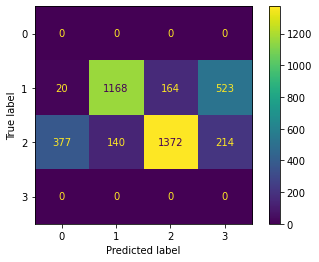

In [38]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

ls = list(range(min_class, 4)) # your y labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ls)
disp.plot()
plt.show()